# Fraud detection lab

## Visualisation (Part 1)

In [1]:
# insert code here

## Part 2

### Preprocessing

In [3]:
# we don't need any of the defined variables of the previous section. Therefore, we clean the workspace.
%reset -f

import sys
!{sys.executable} -m pip install sklearn pandas

Looking in indexes: https://pypi.python.org/simple/


In [4]:
import time
import pandas as pd
import datetime
from sklearn.preprocessing import StandardScaler

In [5]:
CSV_PATH = r"..\data\data_for_student_case.csv"
data_df = pd.read_csv(CSV_PATH)
print(data_df.shape)

(290382, 17)


Remove all the rows in which 'simple_journal' == 'Refused' --> not meaningful datapoints

In [6]:
data_df = data_df[data_df['simple_journal'] != 'Refused']
print(data_df.shape)

(237036, 17)


Transform some of the variables and investigate for NA values

In [7]:
data_df['cvcresponsecode'] = data_df['cvcresponsecode'].apply(lambda cvc: 3 if cvc >= 3 else cvc)

data_df = data_df.loc[~data_df['cardverificationcodesupplied'].isna()]
print(data_df.shape)

# transform labels into 0 and 1
data_df['label'] = data_df['simple_journal'].apply(lambda label: 1 if label == 'Chargeback' else 0)
data_df = data_df.drop(columns = ['simple_journal'])

(223842, 17)


In [8]:
#Extract day of the week and hour from the 'creationdate'
hours = []
day_week = []
month = []
for index, row in data_df.iterrows():
    hours.append(datetime.datetime.strptime(row['creationdate'].split()[1], '%H:%M:%S').hour)
    day_week.append(datetime.datetime.strptime(row['creationdate'].split()[0], '%Y-%m-%d').strftime('%A'))
    month.append(datetime.datetime.strptime(row['creationdate'].split()[0], '%Y-%m-%d').month)

for i in range(len(day_week)):
    if day_week[i] == 'Monday':
        day_week[i] = 0
    elif day_week[i] == 'Tuesday':
        day_week[i] = 1
    elif day_week[i] == 'Wednesday':
        day_week[i] = 2
    elif day_week[i] == 'Thursday':
        day_week[i] = 3
    elif day_week[i] == 'Friday':
        day_week[i] = 4
    elif day_week[i] == 'Saturday':
        day_week[i] = 5
    elif day_week[i] == 'Sunday':
        day_week[i] = 6

print(hours[:5])
print(day_week[:5])
print(month[:5])

data_df['hourtransaction'] = hours
data_df['daytransaction'] = day_week
data_df['monthtransaction'] = month

[23, 4, 14, 7, 18]
[2, 3, 3, 4, 2]
[7, 7, 7, 7, 7]


In [9]:
list(data_df.columns)

['txid',
 'bookingdate',
 'issuercountrycode',
 'txvariantcode',
 'bin',
 'amount',
 'currencycode',
 'shoppercountrycode',
 'shopperinteraction',
 'cardverificationcodesupplied',
 'cvcresponsecode',
 'creationdate',
 'accountcode',
 'mail_id',
 'ip_id',
 'card_id',
 'label',
 'hourtransaction',
 'daytransaction',
 'monthtransaction']

In [10]:
# convert amounts
conversion_rate = {"AUD": 0.626093,
                    "NZD": 0.591501,
                    "SEK": 0.0935468,
                    "GBP": 1.16536,
                    "MXN": 0.0467946}

data_df['amount'] = data_df[['amount', 'currencycode']].apply(lambda row: row['amount']*conversion_rate[row['currencycode']], axis=1)

data_df.head()

,txid,bookingdate,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,cardverificationcodesupplied,cvcresponsecode,creationdate,accountcode,mail_id,ip_id,card_id,label,hourtransaction,daytransaction,monthtransaction
0,1,2015-11-09 14:26:51,MX,mccredit,530056.0,3032.29008,MXN,MX,Ecommerce,True,0,2015-07-01 23:03:11,MexicoAccount,email68370,ip111778,card184798,1,23,2,7
1,2,2015-11-09 14:27:38,MX,mccredit,547046.0,2101.07754,MXN,MX,Ecommerce,True,0,2015-07-02 04:50:55,MexicoAccount,email101299,ip78749,card151595,1,4,3,7
2,3,2015-11-23 16:34:16,MX,mccredit,528843.0,7014.51054,MXN,MX,Ecommerce,True,0,2015-07-02 14:30:28,MexicoAccount,email278604,ip70594,card242142,1,14,3,7
3,4,2015-11-23 16:34:51,MX,mccredit,547146.0,5142.72654,MXN,MX,Ecommerce,True,0,2015-07-03 07:53:37,MexicoAccount,email47409,ip113648,card181744,1,7,4,7
4,5,2015-11-09 14:26:08,MX,visaclassic,477291.0,4206.83454,MXN,MX,Ecommerce,True,0,2015-07-08 18:35:35,MexicoAccount,email205501,ip83553,card97271,1,18,2,7


In [11]:
# encode variables
for col_name in ['issuercountrycode', 'txvariantcode', 'currencycode', 'shoppercountrycode', 'shopperinteraction', 'accountcode']:
    unique_values = data_df[col_name].unique()
    mapped_values = dict(zip(unique_values, range(len(unique_values))))
    data_df[col_name] = data_df[col_name].apply(lambda old_value: mapped_values[old_value])

data_df.head()

,txid,bookingdate,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,cardverificationcodesupplied,cvcresponsecode,creationdate,accountcode,mail_id,ip_id,card_id,label,hourtransaction,daytransaction,monthtransaction
0,1,2015-11-09 14:26:51,0,0,530056.0,3032.29008,0,0,0,True,0,2015-07-01 23:03:11,0,email68370,ip111778,card184798,1,23,2,7
1,2,2015-11-09 14:27:38,0,0,547046.0,2101.07754,0,0,0,True,0,2015-07-02 04:50:55,0,email101299,ip78749,card151595,1,4,3,7
2,3,2015-11-23 16:34:16,0,0,528843.0,7014.51054,0,0,0,True,0,2015-07-02 14:30:28,0,email278604,ip70594,card242142,1,14,3,7
3,4,2015-11-23 16:34:51,0,0,547146.0,5142.72654,0,0,0,True,0,2015-07-03 07:53:37,0,email47409,ip113648,card181744,1,7,4,7
4,5,2015-11-09 14:26:08,0,1,477291.0,4206.83454,0,0,0,True,0,2015-07-08 18:35:35,0,email205501,ip83553,card97271,1,18,2,7


In [12]:
# Check correlation between 'issuercountrycode', 'currencycode', 'shoppercountrycode', 'accountcode'

col_names = ['issuercountrycode', 'currencycode', 'shoppercountrycode', 'accountcode']
temp_df = data_df[col_names]

temp_df.corr()

,issuercountrycode,currencycode,shoppercountrycode,accountcode
issuercountrycode,1.000000,0.684937,0.614083,0.664023
currencycode,0.684937,1.000000,0.643947,0.973466
shoppercountrycode,0.614083,0.643947,1.000000,0.683598
accountcode,0.664023,0.973466,0.683598,1.000000


In [13]:
#'currencycode' and 'accountcode' are strongly correlate: 0.973469 so we only keep one -> 'accountcode'

data_df = data_df.drop(columns = ['currencycode'])
print(data_df.shape)

(223842, 19)


In [14]:
# drop columns which are not used
data_df = data_df.drop(columns=['txid', 'bookingdate', 'creationdate', 'mail_id', 'card_id', 'ip_id', 'bin'])
print(data_df.shape)

(223842, 12)


In [15]:
# Normalize 'amount'
data_df['amount_normalized'] = StandardScaler().fit_transform(data_df['amount'].values.reshape(-1, 1))
data_df = data_df.drop(columns=['amount'])
data_df.head()

,issuercountrycode,txvariantcode,shoppercountrycode,shopperinteraction,cardverificationcodesupplied,cvcresponsecode,accountcode,label,hourtransaction,daytransaction,monthtransaction,amount_normalized
0,0,0,0,0,True,0,0,1,23,2,7,-0.695624
1,0,0,0,0,True,0,0,1,4,3,7,-0.832027
2,0,0,0,0,True,0,0,1,14,3,7,-0.112313
3,0,0,0,0,True,0,0,1,7,4,7,-0.386489
4,0,1,0,0,True,0,0,1,18,2,7,-0.523578


In [16]:
# columns we remain with
list(data_df.columns)

['issuercountrycode',
 'txvariantcode',
 'shoppercountrycode',
 'shopperinteraction',
 'cardverificationcodesupplied',
 'cvcresponsecode',
 'accountcode',
 'label',
 'hourtransaction',
 'daytransaction',
 'monthtransaction',
 'amount_normalized']

In [17]:
# save the file
data_df.to_csv(r'..\data\data_processed_new.csv',index=False)

# Imbalance task

In [18]:
%reset -f

In [19]:
import sys
!{sys.executable} -m pip install imblearn matplotlib

Looking in indexes: https://pypi.python.org/simple/


In [20]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import matplotlib.pyplot as plt
import numpy as np

In [21]:
DATA_PATH = r"../data/"
DATA_FILE = "data_processed_new.csv"
df = pd.read_csv(DATA_PATH + DATA_FILE)
df.head()

,issuercountrycode,txvariantcode,shoppercountrycode,shopperinteraction,cardverificationcodesupplied,cvcresponsecode,accountcode,label,hourtransaction,daytransaction,monthtransaction,amount_normalized
0,0,0,0,0,True,0,0,1,23,2,7,-0.695624
1,0,0,0,0,True,0,0,1,4,3,7,-0.832027
2,0,0,0,0,True,0,0,1,14,3,7,-0.112313
3,0,0,0,0,True,0,0,1,7,4,7,-0.386489
4,0,1,0,0,True,0,0,1,18,2,7,-0.523578


In [22]:
# Let's split into features and labels
y = df['label']
X = df.drop(columns=['label'])

In [23]:
classifiers = [
    ("Ada", AdaBoostClassifier(n_estimators=200)),
    ("rf", RandomForestClassifier(n_estimators=200, n_jobs=-1)),
    ("lr", LogisticRegression(solver='liblinear')),
    ("kNN", KNeighborsClassifier(n_neighbors=5, n_jobs=-1)),
    ("NB", GaussianNB()),
]
smote_values = [0, 0.015, 0.025, 0.05, 0.1, 0.15, 0.25, 0.5, 0.75, 1.0]

In [24]:
# We first split in train and test set. The test set will be only used for plotting the curves.
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

# We then split the train set into train and validation. Validation will be used to select the best smote value.
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, stratify=y_train_val)

Let's now compute, for each of the chosen classifiers, different metrics for different percentages of SMOTE.    
We choose F0.5 as the metric to decide the best value of SMOTE. NOTE: each classifier can have a different SMOTE best parameter!



Using 'Ada'


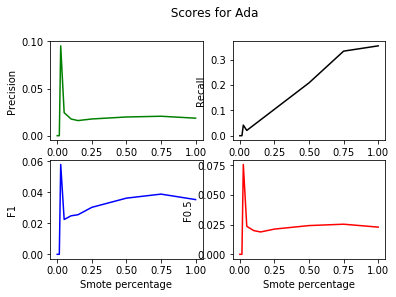

Max 'Precision' --> 0.09523809523809523 (SMOTE perc: 0.025)
Max 'Recall' --> 0.3541666666666667 (SMOTE perc: 1.0)
Max 'F1' --> 0.057971014492753624 (SMOTE perc: 0.025)
Max 'F0.5' --> 0.07575757575757576 (SMOTE perc: 0.025)


Using 'rf'


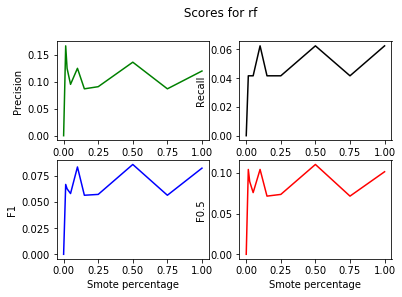

Max 'Precision' --> 0.16666666666666666 (SMOTE perc: 0.015)
Max 'Recall' --> 0.0625 (SMOTE perc: 0.1)
Max 'F1' --> 0.08571428571428572 (SMOTE perc: 0.5)
Max 'F0.5' --> 0.11029411764705882 (SMOTE perc: 0.5)


Using 'lr'


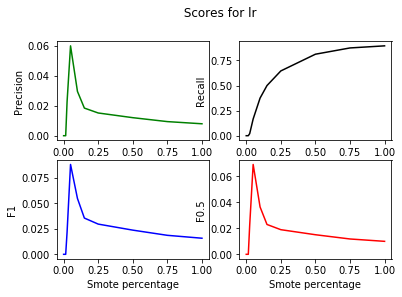

Max 'Precision' --> 0.06015037593984962 (SMOTE perc: 0.05)
Max 'Recall' --> 0.8958333333333334 (SMOTE perc: 1.0)
Max 'F1' --> 0.08839779005524862 (SMOTE perc: 0.05)
Max 'F0.5' --> 0.06896551724137931 (SMOTE perc: 0.05)


Using 'kNN'


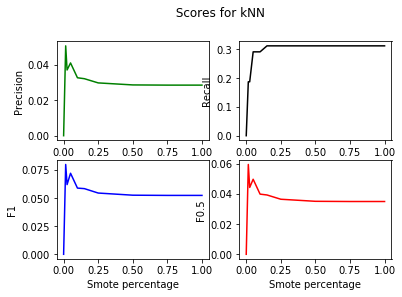

Max 'Precision' --> 0.05084745762711865 (SMOTE perc: 0.015)
Max 'Recall' --> 0.3125 (SMOTE perc: 0.15)
Max 'F1' --> 0.08 (SMOTE perc: 0.015)
Max 'F0.5' --> 0.05952380952380952 (SMOTE perc: 0.015)


Using 'NB'


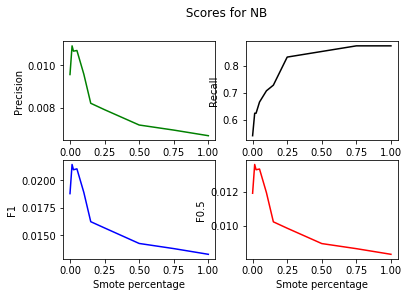

Max 'Precision' --> 0.010913059294288832 (SMOTE perc: 0.015)
Max 'Recall' --> 0.875 (SMOTE perc: 0.75)
Max 'F1' --> 0.021451555237754737 (SMOTE perc: 0.015)
Max 'F0.5' --> 0.01358203549438609 (SMOTE perc: 0.015)
[0.025, 0.5, 0.05, 0.015, 0.015]


In [25]:
best_smotes = []
for clsf_name, clsf in classifiers:
    print(f"\n\nUsing '{clsf_name}'")
    acc = []
    recall = []
    precision = []
    f05_score = []
    f1_score = []
    roc_auc = []
    conf_mat = []
    for smote_perc in smote_values:
        #print(f'--- SMOTE PERCENTAGE: {smote_perc} ---')
        #print(f"Before SMOTE on train: {Counter(y_train)}")
        #print(f"Before SMOTE on validation: {Counter(y_val)}")

        smt = SMOTE(sampling_strategy=smote_perc) if smote_perc else None
        X_smote, y_smote = smt.fit_sample(X_train, y_train) if smote_perc else (X_train, y_train)

        #print(f"After SMOTE on train: {Counter(y_smote)}")
        #print(f"After SMOTE on validation: {Counter(y_val)}")

        clsf.fit(X_smote, y_smote)
        y_pred = clsf.predict(X_val)

        acc.append(metrics.accuracy_score(y_val, y_pred))
        recall.append(metrics.recall_score(y_val, y_pred))
        precision.append(metrics.precision_score(y_val, y_pred))
        f05_score.append(metrics.fbeta_score(y_val, y_pred, beta=0.5))
        f1_score.append(metrics.f1_score(y_val, y_pred))
        roc_auc.append(metrics.roc_auc_score(y_val, y_pred))
        conf_mat.append(metrics.confusion_matrix(y_val, y_pred))

    fig = plt.figure()
    fig.suptitle(f" Scores for {clsf_name}", y=1)

    plt.subplot(2, 2, 1)
    plt.plot(smote_values, precision, color='green', label='precision')
    plt.xlabel("Smote percentage")
    plt.ylabel("Precision")

    plt.subplot(2, 2, 2)
    plt.plot(smote_values, recall, color='black', label='recall')
    plt.xlabel("Smote percentage")
    plt.ylabel("Recall")

    plt.subplot(2, 2, 3)
    plt.plot(smote_values, f1_score, color='blue', label='F1')
    plt.xlabel("Smote percentage")
    plt.ylabel("F1")


    plt.subplot(2, 2, 4)
    plt.plot(smote_values, f05_score, color='red', label='F0.5')
    plt.xlabel("Smote percentage")
    plt.ylabel("F0.5")

    plt.show()

    for metric_name, mets in zip(["Precision", "Recall", "F1", "F0.5", ], [precision, recall, f1_score, f05_score]):
        max_ind = np.argmax(mets)
        print(f"Max '{metric_name}' --> {mets[max_ind]} (SMOTE perc: {smote_values[max_ind]})")
        #print(conf_mat[max_ind])

        if metric_name == "F0.5":
            best_smotes.append(smote_values[max_ind])
            
print(list(best_smotes))

We now retrain the models on train + validation set, and plot the curves using the test set

Ada --> 0.025


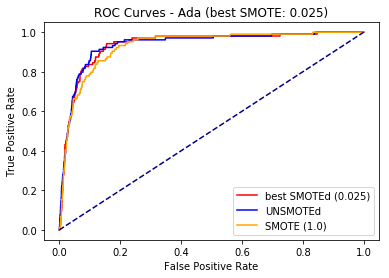

rf --> 0.5


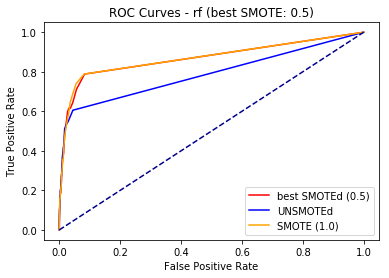

lr --> 0.05


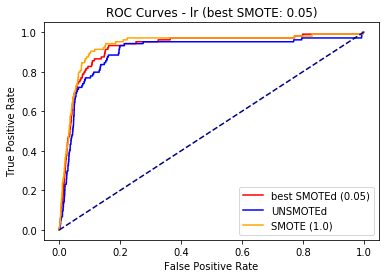

kNN --> 0.015


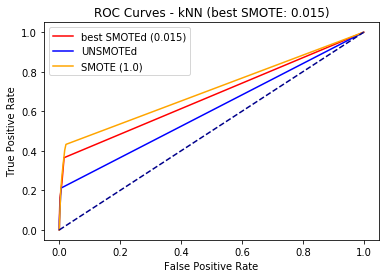

NB --> 0.015


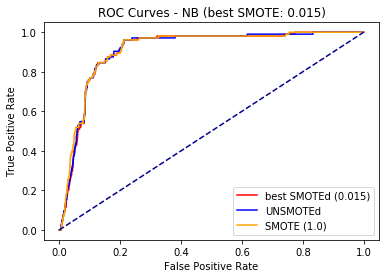

In [26]:
for (clsf_name, clsf), best_smote in zip(classifiers, best_smotes):
    print(f"{clsf_name} --> {best_smote}")

    fpr_smoted = []
    tpr_smoted = []
    if best_smote:
        smt = SMOTE(sampling_strategy=best_smote)
        X_smote, y_smote = smt.fit_sample(X_train_val, y_train_val)
        clsf.fit(X_smote, y_smote)
        y_pred = clsf.predict(X_test)

        probs_smoted = clsf.predict_proba(X_test)
        probs_smoted = probs_smoted[:, 1]
        fpr_smoted, tpr_smoted, _ = roc_curve(y_test, probs_smoted)
        plt.plot(fpr_smoted, tpr_smoted, color='red', label=f'best SMOTEd ({best_smote})')

    clsf.fit(X_train_val, y_train_val)
    y_pred = clsf.predict(X_test)
    probs_smoted = clsf.predict_proba(X_test)
    probs_smoted = probs_smoted[:, 1]
    fpr_unsmoted, tpr_unsmoted, _ = roc_curve(y_test, probs_smoted)
    plt.plot(fpr_unsmoted, tpr_unsmoted, color='blue', label='UNSMOTEd' if best_smote else 'UNSMOTEd (best)')

    if best_smote < 1:
        smt = SMOTE(sampling_strategy=1.0)
        X_full_smote, y_full_smote = smt.fit_sample(X_train_val, y_train_val)
        clsf.fit(X_full_smote, y_full_smote)
        y_pred = clsf.predict(X_test)

    probs_smoted = clsf.predict_proba(X_test)
    probs_smoted = probs_smoted[:, 1]
    fpr_smoted, tpr_smoted, _ = roc_curve(y_test, probs_smoted)
    plt.plot(fpr_smoted, tpr_smoted, color='orange', label="SMOTE (1.0)")
        
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves - {clsf_name} (best SMOTE: {best_smote})')
    plt.legend()
    plt.show()


## Classification (Part 3)

In [27]:
# we reload the data, so variables are not needed
%reset -f

#### White box model

#### Black box model

In [28]:
%reset -f
import sys
!{sys.executable} -m pip install mlxtend

Looking in indexes: https://pypi.python.org/simple/


In [29]:
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE
from mlxtend.classifier import EnsembleVoteClassifier
from sklearn import metrics
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import math

In [30]:
DATA_PATH = r"../data/"
DATA_FILE = "data_processed_new.csv"
df = pd.read_csv(DATA_PATH + DATA_FILE)

y = df['label']
X = df.drop(columns=['label'])

Let's define some useful classifiers, together with their SMOTE parameter and weight for the final ensembling.   
NOTE: these parameters (which are however similar to the ones found in the 'imbalance task' section) have been chosen to try and meet the requirements given in the assignment paper. Also, running again the 'imbalance task' procedure would yield slightly different parameters each time, which are therefore not too significant.

In [31]:
# name, classifier, smote, weight (for ensembling)
k_nn = 5
models = [
    ("Ada", AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), algorithm="SAMME", n_estimators=200), 0.025, 1),
    ("rf", RandomForestClassifier(n_estimators=200, n_jobs=-1), 0.015, 1),
    ("lr", LogisticRegression(solver='liblinear'), 0.5, 1),
    (f"kNN_{k_nn}", KNeighborsClassifier(n_neighbors=k_nn, n_jobs=-1), 0.015, 1),
    ("NB", GaussianNB(), 0.015, 1),
]

First of all, we test each single classifier to serve as baseline. After that, we'll try to combine them to see whether or not we achieve a better performance.

In [32]:
for model_name, clsf, smote_ratio, _ in models:
    print(f"\nTraining {model_name}, smote_ratio: {smote_ratio}")

    conf_mat = np.array([[0, 0], [0, 0]])

    skf = StratifiedKFold(n_splits=10, shuffle=True)
    for idx, (train_index, test_index) in enumerate(skf.split(X, y)):
        #print(f"Fold {idx + 1}")

        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y[train_index], y[test_index]

        smote = SMOTE(sampling_strategy=smote_ratio) if smote_ratio else None
        X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train) if smote_ratio else (X_train, y_train)

        trained = clsf.fit(X_train_smote, y_train_smote)

        y_pred = trained.predict(X_test)
        conf_mat += metrics.confusion_matrix(y_test, y_pred)

    tn, fp, fn, tp = conf_mat.ravel()
    print(conf_mat)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F0.5: {( (1+math.pow(0.5,2))*precision*recall )/( math.pow(0.5,2) * precision + recall )}")


Training Ada, smote_ratio: 0.025
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
Fold 10
[[223218    279]
 [   338      7]]
Precision: 0.024475524475524476
Recall: 0.020289855072463767
F0.5: 0.02350570852921424

Training rf, smote_ratio: 0.015
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
Fold 10
[[223416     81]
 [   321     24]]
Precision: 0.22857142857142856
Recall: 0.06956521739130435
F0.5: 0.1568627450980392

Training lr, smote_ratio: 0.5
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
Fold 10
[[199890  23607]
 [    57    288]]
Precision: 0.012052730696798493
Recall: 0.8347826086956521
F0.5: 0.015011727912431588

Training kNN_5, smote_ratio: 0.015
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
Fold 10
[[222458   1039]
 [   273     72]]
Precision: 0.06480648064806481
Recall: 0.20869565217391303
F0.5: 0.07517226978492379

Training NB, smote_ratio: 0.015
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
Fold

After this, we combine the classifiers. We perform both hard ensembling as well as soft ensembling.    
NOTE: we sum the confusion matrices after each iteration.

In [ ]:
skf = StratifiedKFold(n_splits=10, shuffle=True)
conf_matrices = {}

print("Start crossvalidation! Cross your fingers (and be patient)...")
for idx, (train_index, test_index) in enumerate(skf.split(X, y)):
    print(f"\nFold {idx+1}")
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    trained_clsfs = []
    print("Training single classifiers...")
    for model_name, clsf, smote_ratio, weight in models:
        #print(f"Training {model_name}, smote: {smote_ratio}")
        smote = SMOTE(sampling_strategy=smote_ratio) if smote_ratio else None
        X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train) if smote_ratio else (X_train, y_train)
        trained = clsf.fit(X_train_smote, y_train_smote)
        trained_clsfs.append((trained, weight))

    ens_hard_no_refit = EnsembleVoteClassifier(clfs=[clsf for clsf, _ in trained_clsfs], weights=[weight for _, weight in trained_clsfs],
                                                refit=False, voting="hard")
    ens_soft_no_refit = EnsembleVoteClassifier(clfs=[clsf for clsf, _ in trained_clsfs], weights=[weight for _, weight in trained_clsfs],
                                                refit=False, voting="soft")

    for ensemble, name in zip([ens_hard_no_refit, ens_soft_no_refit],
                              ["Hard", "Soft"]):
        #print(f"Training {name} ensemble")
        fitted = ensemble.fit(X_train, y_train)
        y_pred = fitted.predict(X_test)
        conf_mat = metrics.confusion_matrix(y_test, y_pred)
        conf_matrices[name] = conf_matrices.get(name, np.array([[0, 0], [0, 0]])) + conf_mat
        print(conf_matrices[name])

print("\n\nCrossvalidation finished. Displaying results...")
for name in conf_matrices.keys():
    print(name)
    conf_mat = conf_matrices[name]
    tn, fp, fn, tp = conf_mat.ravel()
    print(conf_mat)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F0.5: {( (1+math.pow(0.5,2))*precision*recall )/( math.pow(0.5,2) * precision + recall )}")

Start crossvalidation! Cross your fingers...

Fold 1
Training single classifiers...
Training Ada, smote: 0.025
Training rf, smote: 0.015
Training lr, smote: 0.5
Training kNN_5, smote: 0.015
Training NB, smote: 0.015
Training Hard ensemble
[[22258    92]
 [   30     5]]
Training Soft ensemble
[[22179   171]
 [   26     9]]

Fold 2
Training single classifiers...
Training Ada, smote: 0.025
Training rf, smote: 0.015
Training lr, smote: 0.5
Training kNN_5, smote: 0.015
Training NB, smote: 0.015
Training Hard ensemble
[[44495   205]
 [   61     9]]
Training Soft ensemble
[[44312   388]
 [   53    17]]

Fold 3
Training single classifiers...
Training Ada, smote: 0.025
Training rf, smote: 0.015
Training lr, smote: 0.5
Training kNN_5, smote: 0.015
Training NB, smote: 0.015
Training Hard ensemble
[[66735   315]
 [   91    14]]
Training Soft ensemble
[[66479   571]
 [   78    27]]

Fold 4
Training single classifiers...
Training Ada, smote: 0.025
Training rf, smote: 0.015
Training lr, smote: 0.5
Tr

## Bonus point

Please, for the BONUS point check the appropriate notebook in the folder.